# Statistical Comparisons Generator

This notebook separates different measurement categories into numerous populations and compares the statistical significance of data trends

In [14]:
#all package imports needed for notebook here
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from scipy.stats import kruskal
import seaborn as sns
import numpy as np
import pprint as pp
from datetime import datetime
from IPython.display import display
import thinkstats2
import thinkplot

df2013 = pd.read_csv('Kwadella_winter_2013_cleaned.csv')
df2014 = pd.read_csv('Kwadella_winter_2014_cleaned.csv')

First we're looking at an analysis of variance between 2014 and 2013 to see how significantly the years differed. We'll look at how the outdoor temperatures varied (as a soft control), then compare the year's pollutant concentrations  to get a read for how well the intervention reduced pollution. We'll do this again with diurnal plots to be sure. 

Cross correlation will let us track dusttraks vs PM2.5 vs PM10 vs CO concentrations and traking the rise and fall of each pollutant over the course of the entire winter. We're starting by just looking at the entire winter, then we may divide pollution measurements based on temperature deviation of a given day or by month

ANOVA is best for comparing one category of measurement at different time points to see if there is significant variance between those groups. for example: 1 way ANOVA done on dusttraks from the mean temp track, dusttraks from 1 sd colder than the mean, and dusttraks from 1 sd warmer than the mean. This measurement would tell us if there is variance in pollution between the three groups. This test could also be applied to 2013 vs 2014 dusttraks to find statistical significance in the differences in pollution before and after intervention

In [36]:
def get_datetime(s):
    """strips date and time from the already existing date column"""
    dt = datetime.strptime(s, "%m/%d/%y %H:%M")
    return dt

def daysSinceStart(df):
    """get time since epoch using a series for month and day
    takes in dataframe and returns the dataframe with an added colum for days since the beginning of data collection"""
    dayArray = np.array(df.Day)
    monthArray = np.array(df.Month)
    
    runningDays = []
    for day, month in zip(dayArray, monthArray):
        if month == 7:
            total_days = 0
        elif month == 8:
            total_days = 31 
        elif month == 9:
            total_days = 61
        else:
            raise ValueError 
        total_days = total_days + day
        runningDays.append(total_days)
    df['DayCount'] = pd.Series(runningDays, index = df.index)
    return df

#Daily Average Outdoor Temp
def compute_avg_temp(df):
    df['DailyAverageTemp'] = df['Temperature_(degC)'].mean()
    return df

#each minute's avg indoor temp
def compute_avg_val(df):
    df['AvgHouse'] = (df['H01-K-E'].mean()+ df['H02-K-N'].mean() + df['H03-K-S'].mean()+ df['H04-K-S'].mean()
                      + df['H05-K-N'].mean()+df['H06-K-N'].mean() + df['H10-K-N'].mean()
                      +df['H11-K-X'].mean()+ df['H12-K-N'].mean() + df['H15-K-S'].mean() +df['H17-K-N'].mean() 
                      + df['H18-K-S'].mean() + df['H20-K-S'].mean()
                      )/13
    return df

def preprocess(df):
    """runs the datetime and daysSinceStart helper functions
    takes and returns a dataframe"""
    res = df.copy()
    datetimes = res.Date.apply(get_datetime)
    res['Hour'] = datetimes.apply(lambda dt: dt.hour)
    res['Day'] = datetimes.apply(lambda dt: dt.day)
    res['Month'] = datetimes.apply(lambda dt: dt.month)
    res['Year'] = datetimes.apply(lambda dt: dt.year)
    res = compute_avg_val(res)
    return res

In [37]:
df2013 = preprocess(df2013)
df2013 = daysSinceStart(df2013)
grouped = df2013.groupby('DayCount')
df2013 = grouped.apply(compute_avg_temp)
df2013 = compute_avg_temp(df2013)
df2013['Dusttraks_(mg/m3)']= df2013['Dusttraks_(mg/m3)']*0.14


df2014 = daysSinceStart(df2014)
grouped = df2014.groupby('DayCount')
df2014 = grouped.apply(compute_avg_temp)
df2014 = compute_avg_temp(df2014)
df2014['Dusttraks_(mg/m3)']= df2014['Dusttraks_(mg/m3)']*0.14

In [45]:
print df2013.head()

   Unnamed: 0  Dusttraks_(mg/m3)  PM10_(ug/m3)  PM2.5_(ug/m3)  SO2_(ppb)  \
0         120                NaN           NaN            NaN        NaN   
1         121                NaN           NaN            NaN        NaN   
2         122                NaN           NaN            NaN        NaN   
3         123                NaN           NaN            NaN        NaN   
4         124                NaN           NaN            NaN        NaN   

   CO_(ppm)  NO_(ppb)  NO2_(ppb)          Date  Temperature_(degC)    ...      \
0       NaN       NaN        NaN  7/2/13 14:00                 NaN    ...       
1       NaN       NaN        NaN  7/2/13 14:01                 NaN    ...       
2       NaN       NaN        NaN  7/2/13 14:02                 NaN    ...       
3       NaN       NaN        NaN  7/2/13 14:03                 NaN    ...       
4       NaN       NaN        NaN  7/2/13 14:04                 NaN    ...       

   H17-K-N  H18-K-S  H20-K-S  Hour  Day  Month  Year  Da

In [5]:
def cross_correlation_using_fft(x, y):
    f1 = fft(x)
    f2 = fft(np.flipud(y))
    cc = np.real(ifft(f1 * f2))
    return fftshift(cc)
 
# shift &lt; 0 means that y starts 'shift' time steps before x # shift &gt; 0 means that y starts 'shift' time steps after x
def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift

In [48]:
def GroupByDay(df,header, func=np.mean):
    """Groups header values by day and compute the daily mean for each category.
    df: DataFrame of environmental data
    returns: DataFrame of daily data
    """
    groups = df[['DayCount', headers]].groupby('DayCount')
    daily = groups.aggregate(func)

    daily['DayCount'] = daily.index
    return daily

def FillMissing(daily,header, span = 3000):
    """Fills missing values with an exponentially weighted moving average.
    Resulting DataFrame has new columns 'ewma' and 'resid'.
    daily: DataFrame of daily values (temperatures, pollution, etc)
    span: window size (sort of) passed to ewma
    returns: new DataFrame of daily prices
    """
    #dates = pd.date_range(daily.index.min(), daily.index.max())
    #reindexed = daily.reindex(dates)

    ewma = pd.ewma(daily[header], span=span)

    resid = (daily[header] - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(resid, len(daily.DayCount))
    daily[header].fillna(fake_data, inplace=True)

    daily['ewma'] = ewma
    daily['resid'] = reindexed.ppg - ewma
    print daily.head()
    return daily

def normalize(df, headers):
    normdf = df[headers].dropna()
    #FillMissing(df, headers))
    #for h in headers:
        #means = pd.rolling_mean(normdf[h],5000, min_periods = 1).shift(-3000) #window is 3000 b/c temp doesn't start until the 3000th entry in the 2013df
        #normdf.loc[:,h] = normdf[h].fillna(means)
    df_norm = (normdf-normdf.mean())/(normdf.max() - normdf.min())
    return df_norm

intHeadCorrList= ['Temperature_(degC)', 'Dusttraks_(mg/m3)', 'PM10_(ug/m3)','PM2.5_(ug/m3)','SO2_(ppb)','CO_(ppm)','NO_(ppb)',
                 'NO2_(ppb)']
dfnorm13 = normalize(df2013, intHeadCorrList)

In [50]:

speardf = dfnorm13.corr(method = 'spearman')
print speardf.head()

                    Temperature_(degC)  Dusttraks_(mg/m3)  PM10_(ug/m3)  \
Temperature_(degC)            1.000000          -0.051971      0.334552   
Dusttraks_(mg/m3)            -0.051971           1.000000      0.359603   
PM10_(ug/m3)                  0.334552           0.359603      1.000000   
PM2.5_(ug/m3)                -0.003481           0.246446      0.366330   
SO2_(ppb)                     0.314639           0.320246      0.484691   

                    PM2.5_(ug/m3)  SO2_(ppb)  CO_(ppm)  NO_(ppb)  NO2_(ppb)  
Temperature_(degC)      -0.003481   0.314639 -0.253483 -0.064890   0.187605  
Dusttraks_(mg/m3)        0.246446   0.320246  0.135695  0.582362   0.410862  
PM10_(ug/m3)             0.366330   0.484691  0.220396  0.205098   0.461499  
PM2.5_(ug/m3)            1.000000   0.232282  0.312534  0.087900   0.319056  
SO2_(ppb)                0.232282   1.000000  0.282412  0.460925   0.763380  


In [11]:
#need to replace nans with a rolling mean, then normalize, then correlate 

In [27]:
crosscorr_array = np.correlate(dfnorm13['Temperature_(degC)'],dfnorm13['Dusttraks_(mg/m3)'], mode = 'full'

In [31]:
corrcoef_matrix = np.corrcoef(dfnorm13['Temperature_(degC)'],dfnorm13['Dusttraks_(mg/m3)'])
print corrcoef_matrix

[[ 1.         -0.01648544]
 [-0.01648544  1.        ]]


This code for a cross correlation heatmap taken from our helpful stack overflow answer http://stackoverflow.com/questions/2318529/plotting-only-upper-lower-triangle-of-a-heatmap

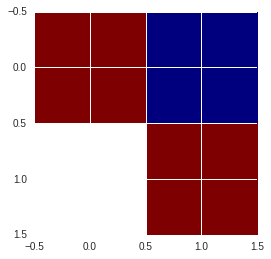

In [26]:
A = crosscorr_matrix #cross correlation matrix

mask =  np.tri(A.shape[0], k=-1)
A = np.ma.array(A, mask=mask) # mask out the lower triangle
fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 10) # jet doesn't have white color
cmap.set_bad('w') # default value is 'k'
ax1.imshow(A, interpolation="nearest", cmap=cmap)
ax1.grid(True)
plt.show()

KeyError: 'Level network must be same as name (None)'

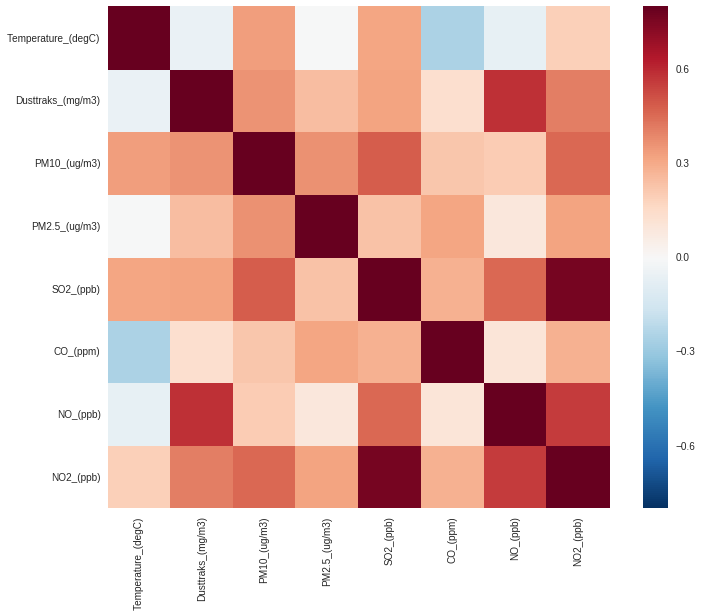

In [51]:
corrmat = speardf

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)

# Use matplotlib directly to emphasize known networks
networks = corrmat.columns.get_level_values("network")
for i, network in enumerate(networks):
    if i and network != networks[i - 1]:
        ax.axhline(len(networks) - i, c="w")
        ax.axvline(i, c="w")
f.tight_layout()

In [15]:
np.random.randint(10, 100, 100).reshape(10, 10)

array([[22, 79, 71, 73, 76, 71, 50, 35, 78, 62],
       [60, 10, 79, 40, 83, 62, 63, 71, 24, 93],
       [56, 12, 97, 85, 68, 16, 32, 51, 17, 88],
       [11, 44, 16, 57, 33, 44, 22, 25, 76, 92],
       [25, 35, 15, 88, 98, 19, 22, 10, 65, 90],
       [50, 56, 83, 67, 43, 24, 50, 85, 66, 55],
       [71, 92, 45, 89, 87, 12, 44, 63, 43, 21],
       [36, 78, 80, 12, 42, 96, 29, 84, 17, 14],
       [12, 69, 67, 34, 65, 15, 25, 38, 38, 54],
       [30, 51, 58, 69, 98, 28, 13, 90, 69, 64]])